In [1]:
import gymnasium as gym
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import time

from agent import Agent

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
plt.ion()

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/niklasschneider/Documents/projects/sop_projekt/venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/niklasschneider/Documents/projects/sop_projekt/venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/niklasschneider/Documents/projects/sop_projekt/venv/lib/pytho

In [2]:
BATCH_SIZE = 64
LEARING_RATE = 0.0005

gamma = 0.999
max_num_episodes = 2500
hidden_size = [128, 64]
min_epsilon = 0.01
max_eps_episodes = 150

print_every = 100

In [3]:
env = gym.make('LunarLander-v3', continuous=False, enable_wind=False)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

threshold = env.spec.reward_threshold

agent = Agent(state_size, action_size, hidden_size, BATCH_SIZE, LEARING_RATE, gamma)

In [4]:
def linear_epsilon_decay(episode) -> float:
    """Linear decrease in 𝜖, whereby the value decreases evenly as the episode increases.
    
    Args:
        episode (int): The current episode number.
        
    Returns:
        float: The 𝜖 value for the current episode.
    """
    return max(min_epsilon, 1.0 - (episode / max_eps_episodes))

In [5]:
def exponential_epsilon_decay(episode):
    """Exponential decrease in 𝜖. Initially, 𝜖 falls rapidly and then asymptotically approaches min_epsilon.
    
    Args:
        episode (int): The current episode number.
        
    Returns:
        float: The 𝜖 value for the current episode.
    """
    return min_epsilon + (1.0 - min_epsilon) * np.exp(-1.0 * episode / max_eps_episodes)

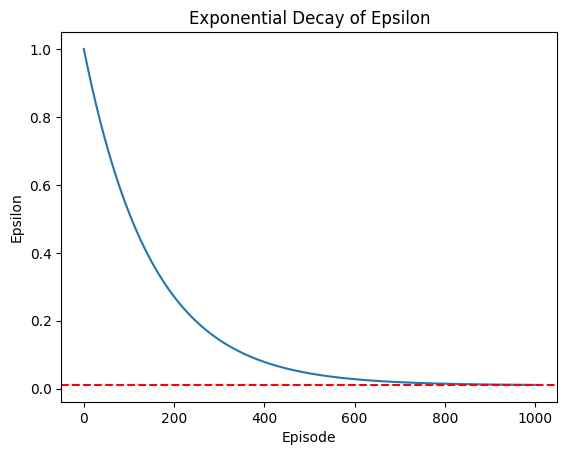

In [6]:
# Beispielaufruf
epsilon_values = [exponential_epsilon_decay(ep) for ep in range(1000)]

# Plot
plt.plot(epsilon_values)
plt.axhline(y=min_epsilon, color="red", linestyle="--", label="min_epsilon")
plt.title("Exponential Decay of Epsilon")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.show()

In [7]:
def run_episode(env, agent, eps):
    """Run a single episode of the environment and train the agent.
    
    Args:
        env (gym.Env): The environment to run.
        agent (Agent): The agent to use.
        eps (float): The epsilon value to use for the episode.
        
    Returns:
        float: The total reward for the episode.
    """
    state = env.reset()[0]
    done = False
    total_reward = 0
    
    while not done:
        action = agent.get_action(FloatTensor([state]), eps)
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        total_reward += reward
        
        done = terminated or truncated
        
        if done:
            reward = -1
            
        agent.replay_buffer.push(
            (FloatTensor([state]), 
            action,
            FloatTensor([reward]),
            FloatTensor([next_state]), 
            FloatTensor([done]))
        )
        
        agent.learn()
            
        state = next_state
        
    return total_reward

In [8]:
def train_agent(env, agent, max_num_episodes, print_every, threshold, epsilon_decay_fn):
    scores_array = []
    avg_scores_array = []
    cumulative_score = 0
    
    time_start = time.time()
    
    for episode in range(max_num_episodes):
        eps = epsilon_decay_fn(episode)
        score = run_episode(env, agent, eps)
        
        scores_array.append(score)
        
        if len(scores_array) == 1:
            cumulative_score = score
        else:
            cumulative_score += score
            if len(scores_array) > print_every:
                cumulative_score -= scores_array[-print_every - 1]
        
        avg_score = cumulative_score / min(len(scores_array), print_every)
        avg_scores_array.append(avg_score)
        
        if episode % print_every == 0 or episode == max_num_episodes-1:
            dt = int(time.time() - time_start)
            time_start = time.time()
            print(f"Episode {episode} - Score: {score} - Avg Score: {avg_score:.2f} - Epsilon: {eps:.4f} - Time: {dt}s")
        
    return scores_array, avg_scores_array

In [9]:
scores, avg_scores = train_agent(env, agent, max_num_episodes, print_every, threshold, exponential_epsilon_decay)

Episode 0 - Score: -78.70969870937702 - Avg Score: -78.71 - Epsilon: 1.0000 - Time: 0s
Episode 100 - Score: -236.1856089088592 - Avg Score: -114.05 - Epsilon: 0.5183 - Time: 20s
Episode 200 - Score: 90.67792878580543 - Avg Score: -22.76 - Epsilon: 0.2710 - Time: 54s
Episode 300 - Score: 266.90098075902455 - Avg Score: 48.17 - Epsilon: 0.1440 - Time: 74s
Episode 400 - Score: -25.874124636877497 - Avg Score: 128.16 - Epsilon: 0.0788 - Time: 59s
Episode 500 - Score: 224.3465203653432 - Avg Score: 144.85 - Epsilon: 0.0453 - Time: 61s
Episode 600 - Score: 226.11494063588123 - Avg Score: 168.60 - Epsilon: 0.0281 - Time: 56s
Episode 700 - Score: 246.07940235109282 - Avg Score: 202.10 - Epsilon: 0.0193 - Time: 49s
Episode 800 - Score: 51.95343300646434 - Avg Score: 198.07 - Epsilon: 0.0148 - Time: 45s
Episode 900 - Score: 220.10179282953544 - Avg Score: 140.00 - Epsilon: 0.0125 - Time: 49s
Episode 1000 - Score: 281.4618425466522 - Avg Score: 153.79 - Epsilon: 0.0113 - Time: 45s
Episode 1100 - 

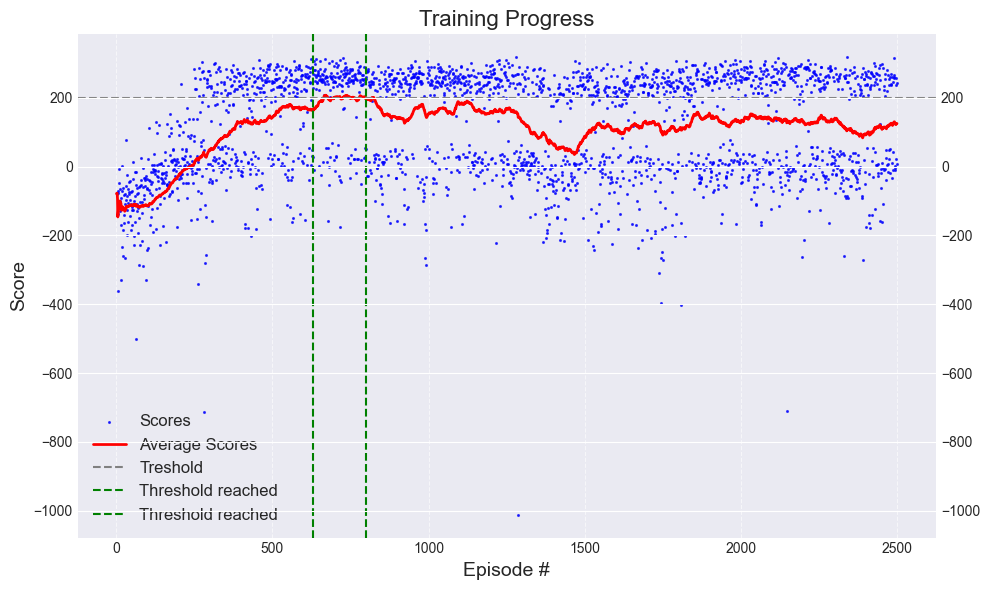

In [23]:
plt.style.use("seaborn-v0_8-darkgrid")

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(np.arange(1, len(scores) + 1), scores, label="Scores", color="blue", alpha=0.7, s=1.5)
ax.plot(np.arange(1, len(avg_scores) + 1), avg_scores, label="Average Scores", color="red", linewidth=2)
plt.axhline(y=threshold, color="grey", linestyle="--", label="Treshold")
plt.axvline(x=630, color="green", linestyle="--", label="Threshold reached")
plt.axvline(x=800, color="green", linestyle="--", label="Threshold reached")

ax.set_title("Training Progress", fontsize=16)
ax.set_xlabel("Episode #", fontsize=14)
ax.set_ylabel("Score", fontsize=14)

ax.legend(loc="best", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())

plt.tight_layout()
plt.show()

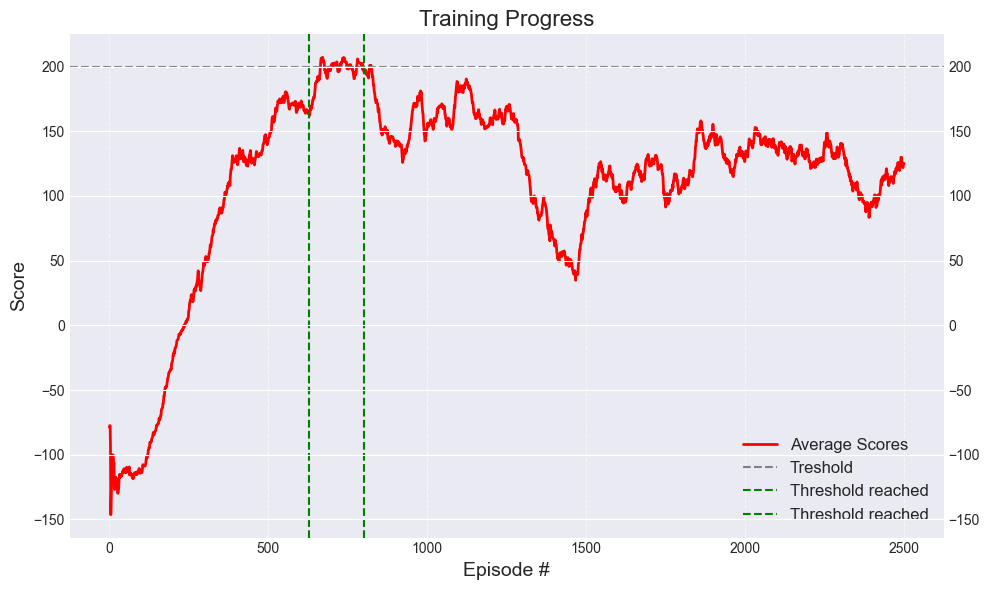

In [22]:
plt.style.use("seaborn-v0_8-darkgrid")

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.arange(1, len(avg_scores) + 1), avg_scores, label="Average Scores", color="red", linewidth=2)
plt.axhline(y=threshold, color="grey", linestyle="--", label="Treshold")
plt.axvline(x=630, color="green", linestyle="--", label="Threshold reached")
plt.axvline(x=800, color="green", linestyle="--", label="Threshold reached")

ax.set_title("Training Progress", fontsize=16)
ax.set_xlabel("Episode #", fontsize=14)
ax.set_ylabel("Score", fontsize=14)

ax.legend(loc="best", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())

plt.tight_layout()
plt.show()